In [1]:
from xgboost import XGBRegressor as XGBR
from sklearn.linear_model import LinearRegression as LR
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def preproc(_df):
    _df['강수량(mm)']=_df['강수량(mm)'].fillna(0)
    _df['적설(cm)']=_df['적설(cm)'].fillna(0)
    _df=_df.dropna(axis=0)
    return _df

In [3]:
df=pd.read_csv("OBS_ASOS_TIM_20230318155150.csv",encoding='cp949')
df2=pd.read_csv("OBS_ASOS_TIM_20230317173225.csv",encoding='cp949')
df=preproc(df)
df2=preproc(df2)

In [5]:
def calcByMagnus_Tetens(air_temperature,humidity,atm_pressure):
    alpha = 17.27
    beta = 237.7
    gamma = ((alpha * air_temperature) / (beta + air_temperature)) + math.log(humidity/100.0)
    es = 6.112 * math.exp(gamma) * (atm_pressure/1013.25)**(1.0 - 0.00075 * air_temperature)
    gamma_dp = math.log(es/6.112)
    dew_point = (beta * gamma_dp) / (alpha - gamma_dp)
    return dew_point

In [6]:
ld=XGBR()
ld.fit(df[['기온(°C)', '강수량(mm)', '습도(%)','현지기압(hPa)', '적설(cm)', '지면온도(°C)']],df['이슬점온도(°C)'])
ld.score(df2[['기온(°C)', '강수량(mm)', '습도(%)','현지기압(hPa)', '적설(cm)', '지면온도(°C)']],df2['이슬점온도(°C)'])

0.9995827204581111

In [7]:
df2['out_MT']=df2.apply(lambda x:calcByMagnus_Tetens(x['기온(°C)'],x['습도(%)'],x['현지기압(hPa)']),axis=1)
df2['out_XGGR']=ld.predict(df2[['기온(°C)', '강수량(mm)', '습도(%)',
       '현지기압(hPa)', '적설(cm)', '지면온도(°C)']])

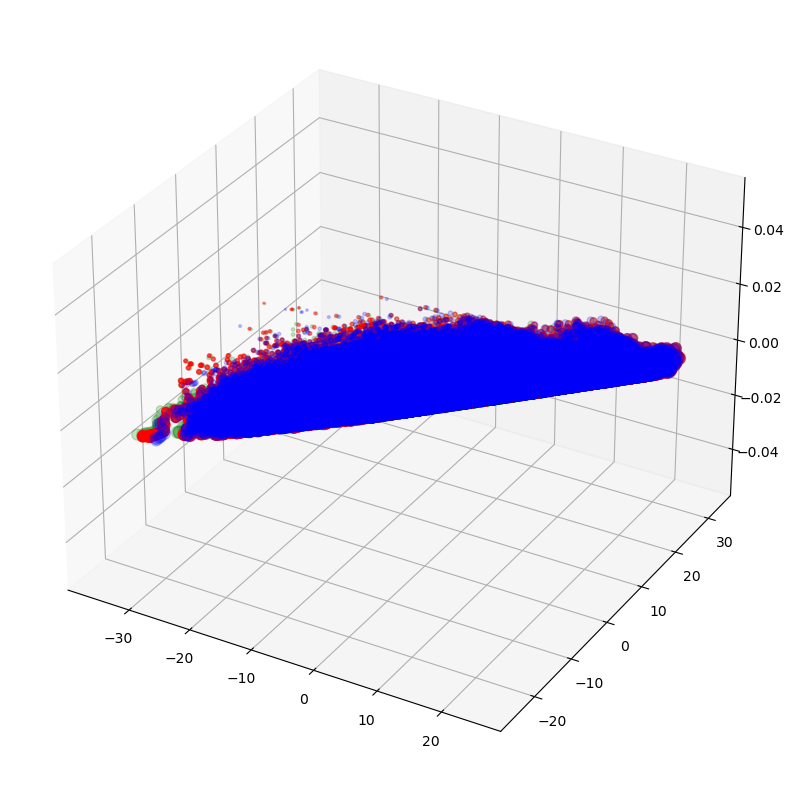

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

plt.scatter(df2['out_MT'],df2['기온(°C)'],df2['습도(%)'],c='g',alpha=0.2)
plt.scatter(df2['out_XGGR'],df2['기온(°C)'],df2['습도(%)'],c='b',alpha=0.2)
plt.scatter(df2['이슬점온도(°C)'],df2['기온(°C)'],df2['습도(%)'],c='r')

In [10]:
def get_r2_score(y_true, y_pred):
    from sklearn.metrics import r2_score
    return r2_score(y_true, y_pred)
def get_rmse(y_true, y_pred):
    from sklearn.metrics import mean_squared_error
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [11]:
print('R2 MT: ',get_r2_score(df2['이슬점온도(°C)'],df2['out_MT']))
print('R2 XGGR: ',get_r2_score(df2['이슬점온도(°C)'],df2['out_XGGR']))

R2 MT:  0.9995357003089701
R2 XGGR:  0.9995827204581111


In [14]:
print('RMSE MT: ',get_rmse(df2['이슬점온도(°C)'],df2['out_MT']))
print('RMSE XGGR: ',get_rmse(df2['이슬점온도(°C)'],df2['out_XGGR']))

RMSE MT:  0.18869401623225254
RMSE XGGR:  0.17888440360783914


In [16]:
print('MAX ABS ERROR MT: ',abs(df2['out_MT']-df2['이슬점온도(°C)']).max())
print('MAX ABS ERROR XGGR: ',abs(df2['out_XGGR']-df2['이슬점온도(°C)']).max())

MAX ABS ERROR MT:  1.4554768746932076
MAX ABS ERROR XGGR:  5.02352600097656


In [19]:
df2[['이슬점온도(°C)','out_MT','out_XGGR']].to_csv('compare.csv',index=False, encoding='cp949')

In [17]:
df2.head()

,지점,지점명,일시,기온(°C),강수량(mm),습도(%),이슬점온도(°C),현지기압(hPa),적설(cm),지면온도(°C)
0,90,속초,2022-10-01 00:00,19.1,0.0,59.0,10.8,1011.8,0.0,16.3
1,90,속초,2022-10-01 01:00,20.0,0.0,47.0,8.3,1011.9,0.0,16.0
2,90,속초,2022-10-01 02:00,21.0,0.0,43.0,7.9,1012.1,0.0,15.5
3,90,속초,2022-10-01 03:00,22.3,0.0,39.0,7.6,1012.1,0.0,15.8
4,90,속초,2022-10-01 04:00,20.7,0.0,45.0,8.3,1012.3,0.0,15.8


<AxesSubplot:>

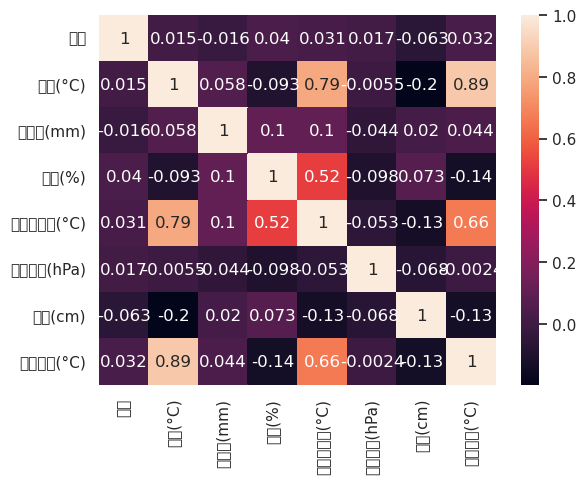

In [15]:
import seaborn as sns
#한글처리
from matplotlib import font_manager, rc

font_path = 'C:/Windows/Fonts/gulim.ttc'
plt.rcParams['axes.unicode_minus'] = False
sns.set(font=font_path, rc={"axes.unicode_minus":False}, style='darkgrid')
sns.heatmap(df2.corr(),annot=True)


In [27]:
"""
This script compares the predictions of dew point temperature using two methods: 
1) Magnus-Tetens formula, and 
2) XGBoost Regression. 

The input data are two CSV files containing weather observations, and the output is a plot and a CSV file 
comparing the predicted and actual dew point temperatures. 

Functions:
----------
- get_r2_score(y_true, y_pred):
    Calculates and returns the R-squared score of the predicted values `y_pred` compared to the actual 
    values `y_true`.

- get_rmse(y_true, y_pred):
    Calculates and returns the root mean squared error (RMSE) of the predicted values `y_pred` compared 
    to the actual values `y_true`.

- preproc(_df):
    Preprocesses the input DataFrame `_df` by filling NaN values and dropping rows with missing data.

- calc_by_MagnusTetens(air_temperature, humidity, atm_pressure):
    Calculates the dew point temperature using the Magnus-Tetens formula based on the input air temperature, 
    humidity, and atmospheric pressure.

Input data:
-----------
- Two CSV files containing weather observations: "OBS_ASOS_TIM_20230318155150.csv" and 
  "OBS_ASOS_TIM_20230317173225.csv".

Output files:
-------------
- "compare.png": a 3D scatter plot comparing the predicted and actual dew point temperatures using the 
  Magnus-Tetens formula and XGBoost Regression.

- "compare.csv": a CSV file containing the actual dew point temperature, the predicted dew point temperature 
  using the Magnus-Tetens formula, and the predicted dew point temperature using XGBoost Regression.

Dependencies:
-------------
- pandas, math, numpy, matplotlib, mpl_toolkits.mplot3d, and sklearn.metrics from scikit-learn.
- xgboost.XGBRegressor from XGBoost.

""" 

from xgboost import XGBRegressor as XGBR
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def get_r2_score(y_true, y_pred):
    from sklearn.metrics import r2_score

    return r2_score(y_true, y_pred)


def get_rmse(y_true, y_pred):
    from sklearn.metrics import mean_squared_error

    return np.sqrt(mean_squared_error(y_true, y_pred))


def preproc(_df):
    _df["강수량(mm)"] = _df["강수량(mm)"].fillna(0)
    _df["적설(cm)"] = _df["적설(cm)"].fillna(0)
    _df = _df.dropna(axis=0)
    return _df


def calc_by_MagnusTetens(air_temperature, humidity, atm_pressure):
    alpha = 17.27
    beta = 237.7
    gamma = ((alpha * air_temperature) / (beta + air_temperature)) + math.log(
        humidity / 100.0
    )
    es = (
        6.112
        * math.exp(gamma)
        * (atm_pressure / 1013.25) ** (1.0 - 0.00075 * air_temperature)
    )
    gamma_dp = math.log(es / 6.112)
    dew_point = (beta * gamma_dp) / (alpha - gamma_dp)
    return dew_point

def calc_by_MagnusTetens2(air_temperature, humidity):
    alpha = 17.27
    beta = 237.7
    gamma_dp = ((alpha * air_temperature) / (beta + air_temperature)) + math.log(humidity / 100.0)
    dew_point = (beta * gamma_dp) / (alpha - gamma_dp)
    return dew_point


df = pd.read_csv("OBS_ASOS_TIM_20230318155150.csv", encoding="cp949")
df2 = pd.read_csv("OBS_ASOS_TIM_20230317173225.csv", encoding="cp949")
df = preproc(df)
df2 = preproc(df2)

#xgbr = XGBR()
#xgbr.fit(
#    df[["기온(°C)", "강수량(mm)", "습도(%)", "현지기압(hPa)", "적설(cm)", "지면온도(°C)"]],
#    df["이슬점온도(°C)"],
#)
#xgbr.score(
#    df2[["기온(°C)", "강수량(mm)", "습도(%)", "현지기압(hPa)", "적설(cm)", "지면온도(°C)"]],
#    df2["이슬점온도(°C)"],
#)
#
df2["out_XGBR"] = df2.apply(
    lambda x: calc_by_MagnusTetens(x["기온(°C)"], x["습도(%)"], x["현지기압(hPa)"]), axis=1)
df2["out_MT"] = df2.apply(
    lambda x: calc_by_MagnusTetens2(x["기온(°C)"], x["습도(%)"]), axis=1
)
#df2["out_XGBR"] = xgbr.predict(
#    df2[["기온(°C)", "강수량(mm)", "습도(%)", "현지기압(hPa)", "적설(cm)", "지면온도(°C)"]]
#)

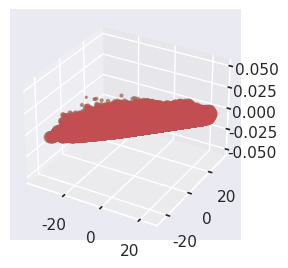

In [28]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection="3d")
plt.scatter(df2["out_MT"], df2["기온(°C)"], df2["습도(%)"], c="g", alpha=0.4)
plt.scatter(df2["이슬점온도(°C)"], df2["기온(°C)"], df2["습도(%)"], c="r", alpha=0.4)

In [29]:

print("R2 MT: ", get_r2_score(df2["이슬점온도(°C)"], df2["out_MT"]))
print("R2 XGGR: ", get_r2_score(df2["이슬점온도(°C)"], df2["out_XGBR"]))
print("RMSE MT: ", get_rmse(df2["이슬점온도(°C)"], df2["out_MT"]))
print("RMSE XGGR: ", get_rmse(df2["이슬점온도(°C)"], df2["out_XGBR"]))
print("MAX ABS ERROR MT: ", abs(df2["out_MT"] - df2["이슬점온도(°C)"]).max())
print("MAX ABS ERROR XGGR: ", abs(df2["out_XGBR"] - df2["이슬점온도(°C)"]).max())



R2 MT:  0.9999634784666213
R2 XGGR:  0.9995357003089701
RMSE MT:  0.0529216568699068
RMSE XGGR:  0.18869401623225254
MAX ABS ERROR MT:  0.16391682038526767
MAX ABS ERROR XGGR:  1.4554768746932076
